**Author**: Yap Jheng Khin

**FYP II Title**: Used car dealership web application

**Purpose**:
- This notebook highlights the transfer learning process from traditional random forest regressor (Scikit-learn API) to adaptive random forest regressor (River API).
- Ouput
    - Experiment data for reproducibility.
    - Data preprocessor for reproducibility. 
    - Trained TRF for reproducibility. 
    - ARF regressor with the transfered weight. 
    - Diagram of the first decision tree and Hoeffding tree for comparison.
    - Log files that prove the correctness of the transfer learning algorithm.

**Technical jargon**
1. ARF - Adaptive random forest
2. TRF - Traditional random forest

**Execution time**: At most 3 minutes in Jupyter Notebook with 8 processor cores.

# Setup

Ensure that the current Python interpreter path is correct. For example, if the **River conda environment** is named as **arf_conda_env**, the expected `sys.executable` should be C:\Users\User\miniconda3\envs\\**arf_conda_env**\\python.exe.

In [ ]:
import sys
print(sys.executable)

## Import

Import libraries.

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import pickle
import random

# scikit-learn model
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree as sklearn_tree

# River model and its components
from river.ensemble import AdaptiveRandomForestRegressor
from river.drift import ADWIN

# Data Generator
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# User libraries
from data_preprocessing import DataPreprocessor
from arf_rg_transfer_learning import transfer_learning, transfer_tree_weights_test, dt_fetch_data
from arf_training import train_arf_rg

Initialise seed for reproducibility.

In [2]:
#Intialise a random number generator
# Source: https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
RANDOM_SEED = 2022
RANDOM_NUMBER_GENERATOR = np.random.default_rng(RANDOM_SEED)

OUT_PARENT_DIR = 'outputs'
OUT_CHILD_DIR = 'rg_transfer_learning'
OUT_FOLDER_PATH = os.path.join(OUT_PARENT_DIR, OUT_CHILD_DIR) 

# Create directory if not exist
os.makedirs(OUT_FOLDER_PATH, exist_ok=True)

##  Data Setup

No concept drift stream generators are used since none of the generated stream can train well with the traditional random forest regressor. Instead, the California housing dataset is used since the traditional random forest can be trained well with it. The TRF is trained with this dataset before its training weights are transferred to the ARF. The target is the median house price and the drift is manually induced by increasing the price by 25% due to economic factors like inflation or war.

In [3]:
X, y = fetch_california_housing(data_home=os.path.join(OUT_FOLDER_PATH), 
                                download_if_missing=True, 
                                return_X_y=True, 
                                as_frame=True)

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

train_set = X_train.copy()
train_set[y_train.name] = y_train
test_set = X_test.copy()
test_set[y_test.name] = y_test

# Export data for reproducibility
train_set.to_csv(os.path.join(OUT_FOLDER_PATH, 'cal_housing_train_set.csv'), index=False)
test_set.to_csv(os.path.join(OUT_FOLDER_PATH, 'cal_housing_test_set.csv'), index=False)

num_attrs = X.columns
cat_attrs = []
y_attr = y.name

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (16512, 8)
y_train shape (16512,)
X_test shape (4128, 8)
y_test shape (4128,)


# Training

## Random Forest

### Model Setup

In [4]:
trf_rg_params = {
    # Random forest hyperparameters
    'n_estimators': 100, # Train 100 decision trees
    'criterion': 'squared_error', # Use mean squared error as feature selection criterion
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'random_state': RANDOM_SEED,
    
    # Traditional random forest algorithm-specific hyperparameters
    'bootstrap': True, # Different subset of dataset in each tree
    'max_leaf_nodes': None, # Can produce unlimited number of leaf nodes
    'min_samples_leaf': 1, # Miminum number of samples required to be at leaf node
    'min_samples_split': 50, # Minimum number of samples to split node. Must match with grace period.
    'min_weight_fraction_leaf': 0.0, # Samples have equal weight at leaf node

    # Utility parameters
    'n_jobs': -1, # Use all available processors
    'verbose': 0,
    'warm_start': False, # Fit a whole new forest
}

### Training

Initialise data preprocessor.

In [5]:
# Preprocess data
data_pp = DataPreprocessor(X_train, num_attrs, cat_attrs)

Perform hyperparameter tunning to optimise TRF.

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Relevant hyperparameters to reduce generalisation errors
trf_rg_param_dist = {
    'n_estimators': [5, 10, 15, 20], # The number of decision trees
    'max_depth': [5, 10, 15, 20], # The maximum depth of decision trees
}

# Training
duration = 0
start = time.time()

trf_rg_cv = RandomizedSearchCV(
    RandomForestRegressor(**trf_rg_params), trf_rg_param_dist, 
    n_iter = 8, scoring = 'neg_mean_absolute_error', n_jobs = -1, 
    refit=True, cv = 10, verbose = 10, 
    random_state = RANDOM_SEED, return_train_score = False)

X_train_pp = data_pp.preprocess(X_train)

trf_rg_search = trf_rg_cv.fit(X_train_pp, y_train)

end = time.time()
duration += end - start
print(f'\nTime taken for tunning TRF: {duration} seconds')

Fitting 10 folds for each of 8 candidates, totalling 80 fits

Time taken for tunning TRF: 8.246678590774536 seconds


Fit the TRF using the best hyperparameter settings.

In [7]:
# Training
duration = 0
start = time.time()

# Update the hyperparameters
for param_name, param_value in trf_rg_search.best_params_.items():
    trf_rg_params[param_name] = param_value
# Define a regressor
trf_rg = RandomForestRegressor(**trf_rg_params)

trf_rg.fit(X_train_pp, y_train)

end = time.time()
duration += end - start

print(f'\nTime taken for training TRF: {duration} seconds')


Time taken for training TRF: 0.19833946228027344 seconds


Below is the overall description of the fitted TRF regressor.

In [8]:
total_depth = 0
total_estimators = trf_rg.n_estimators
print(f'The total number of base learners is {trf_rg.n_estimators}.')

for estimator in trf_rg.estimators_:
    total_depth += estimator.get_depth()

print(f'The depth of each base learner is {math.floor(total_depth/total_estimators)} on average.')

The total number of base learners is 15.
The depth of each base learner is 15 on average.


## Hoeffding tree

### Model Setup


In [9]:
river_adwin = ADWIN(delta = 0.002)

river_arf_rg_params = {
    # Relevant hyperparameters
    'n_models': len(trf_rg.estimators_), # Number of base learners
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'seed': RANDOM_SEED,

    # Adaptive algorithm-specific hyperparamters
    'binary_split': True, # Enforce binary split and disable multi-way split
    'disable_weighted_vote': False, # Enable weighted vote prediction
    'drift_detector': river_adwin, # Drift Detection method.
    'grace_period': 50, # Number of instances a leaf should observe between split attempts
    'lambda_value': 6, # The lambda value for bagging
    'leaf_prediction': 'mean', # Use the target mean as the prediction mechanism at leaves
    'split_confidence': 0.01, # Allowed error in split decision
    'splitter': None, # Use tree.splitter.EBSTSplitter to monitor the class statistics and perform splits
    'tie_threshold': 0.05, # Threshold below which a split will be forced to break ties. 
    'warning_detector': river_adwin, # Warning Detection method.

    # Utility parameters
    'nominal_attributes': data_pp.nominal_attrs, # List of nominal attributes.
    'merit_preprune': False #  Disable merit-based tree pre-pruning.
}

### Transfer Learning

The source code for transfer learning can be found at **arf_rg_transfer_learning.py**.

*A)* Pseudocode for transfer_tree_weights is as shown below:

```
FOR each hoeffding_tree
    ENQUEUE root_node to queue
    
    WHILE queue is not empty
        DEQUEUE node from queue
        
        Retrieve left and right child indexes from the corresponding node in decision_tree
        
        IF left child index is -1 (node is a leaf node)
            CALL learn_many to update the node's statistics and splitters
        ELSE
            Retrieve split feature and split value from the corresponding node in decision_tree
            
            IF split feature is categorical
                Update the split value to 0
            
            CREATE branch_node and two child_node
            ATTACH the two child_node to the branch_node
            REATTACH branch_node to its parent to update object reference
            
            CALL update_parent_stats to update the branch_node's statistics
            
            ENQUEUE the two child_node into queue
```

The transfer learning process for regressors is similar to the process for classifiers. The only difference is the prediction value. Both ARF and TRF's prediction value is an arbitary number. For the leaf nodes, the number are directly used as the prediction value.

For regressors, the prediction value is not directly copied to the newly created branch node's object and leaf node's object in the ARF during transfer learning. It is because the Hoeffding tree does not directly store the prediction value but uses `river.stats.Var` class instance to store statistical information that retrieve the prediction value. To update the statistics at branch nodes and leaf nodes, `river.stats.Var` class instance must be initialised and updated with with the target value of the samples that arrived at the current node.

The split value is overriden with value 0 whenever the split feature is categorical. It is because split conditions are different for both scikit-learn implementation of decision tree and River implementation of Hoeffding tree. For TRF, the split value is set at 0.5 and the leaf node's traversal happens when the feature value is less than 0.5. For ARF, the split value is set at a categorical value and the leaf node's traversal happens when the feature value is exactly equivalent to the split value. Thus, it is assumed all the nominal features are one-hot encoded, such that the TRF's split value is always 0.5 for easier implementation of transfer leearning.

Due to time constraint, the transfer learning regressor algorithm has limitations. 

1. The algorithm only supports the transfer of weights between single-output regressors, but not multi-output regressors. A multi-output regressor is a regressor that predicts more than one numerical variables using the same set of features. 

2. The algorithm also only supports the update of two specific splitters in Hoeffding tree. The two splitters are the <a href="https://riverml.xyz/latest/api/tree/splitter/EBSTSplitter/">EBSTSplitter</a> for the numerical splitter and <a href="https://github.com/online-ml/river/blob/c0c88d38b96c99de3e3646005c3ded1bfee47e47/river/tree/splitter/nominal_splitter_reg.py#L10">NominalSplitterReg</a> for nominal splitter. 

3. The algorithm only supports transferring to Hoeffding trees that are configured to use **target mean** leaf prediction mechanism, but not **model** mechanism or **adaptive** mechanism. 

4. The pre-trained Hoeffding trees can only perform binary split, but not multi-way split. The Hoeffding tree is enforced to only perform binary split since scikit-learn decision tree only performs binary split. 

Logically speaking, the max depth allowed in Hoeffding tree must be equivalent or larger than the max depth allowed in decision tree for the transfer learning to work as expected. Note that the transfer learning algorithm is not fully tested when the merit-based tree pre-pruning is enabled.

Based on the limitation above, the hyperparameter of TRF and ARF must be set as shown below:
```python
river_arf_rg_params = {
    'n_models': len(trf_rg.estimators_), # Number of base learners must be the same with TRF
    'max_depth': None, # Should be equal or larger than max_depth in decision tree
    'binary_split': True, # Enforce binary split and disable multi-way split
    'leaf_prediction': 'mean', # Use the target mean as the prediction mechanism at leaves
    'splitter': None, # Use tree.splitter.EBSTSplitter to monitor the class statistics and perform splits
    
    # Hyperparameter that is not fully tested
    'merit_preprune': False #  Disable merit-based tree pre-pruning.
}
```

To ensure the compatibility with SHAP tree explainer from SHAP library, two hyperparameters must have a fixed value, respectively. First, the `disable_weighted_vote` must be set to `False` to disable weighted vote prediction. Second, the `aggregation_method` must be set to `mean`. It is because the model that is ingested into SHAP tree explainers output prediction values by averaging the equally weighted predictions across all base learners. If these two hyperparameters are not correctly set, the SHAP-ingested model will output different prediction values, which causes the SHAP value calculation to be inaccurate.

*B)* To speed up the transfer learning process, `learn_many` is only called at the leaf nodes to update the statistics and splitters. It is because:
1. The statistical information is important for leaf nodes to output predictions.
2. The splitters information is important for leaf nodes to make split attempts  during incremental learning. 

The details of updating statistics updating are shown as below:

1. Update the Hoeffding tree's node's `stats` attribute with the target variable of the samples that arrived at the node. The resulting `stats` is an instance of `river.stats.Var`. According to the <a href="">River source code</a>, `river.stats.Var` is a running variance implemented using Welford's algorithm. When performing inference, the `stats` attribute retrieves the latest running mean as the predicted value for that node. During incremental learning, the running variance and running mean is updated in the `stats` attribute as new samples arrived. 

2. Based on the updated `stats` attribute, initialise and update the `splitter` for each feature. The `splitter` will be used to determine the best split feature and recommend split values as more samples are received later.

*C)* The transfer learning process is sped up using implementations stated below. 

<u>Improvement</u>
1. Numpy is applied to vectorize all the operations that involve in updating nodes' statistics. Instead of calling the function `learn_one` for each sample, a vectorised function named `learn_many` is called only once per node.
2. Joblib is used to enable process-based parallelism. Transfering weights between ensembles is broken down into smaller tasks. For each small task, a process is spawned to transfer weights between a decision tree and a Hoeffding tree.

*D)* Regardless, the transfer learning process is still way too slower than the training of the TRF. It took about 10 minutes to transfer 15 base learners of maximum depth of 15 from TRF to ARF. Thus, the potential improvement of the algorithm is shown below.

<u>Potential improvement</u>
1. **Cython**. Cython is a superset of Python programming langauge that can reduce overhead and improve performance. The compiler converts the Cython code into highly-optimised C code or C++ code. The low-level code is then compiled as Python extension module and can be imported just like a normal Python library. In short, Cython allows developer to write Python code with native C performance.
2. **C extensions with thread-based parallelism**. Improve performance in parallelism by switching from process-based parallelism to thread-based parallelism. Thread-based parallelism is faster since the overhead in exchanging information between threads are lower than the overhead between processes. It especially worked well for Cython extension modules that seldom execute CPython code or access Python objects. Taking CPU-bound machine learning algorithm as an example. Since the algorithm like ARF from River API is fully implemented in CPython, the algorithm cannot take the full advantage of multi-threading. It because Global Interpreter Lock (GIL) only allows one and only one thread to execute CPython bytecode at any given time. One solution is to migrate the bottleneck code to Cython extension modules. Using `with nogil` statement, Cython extensions can temporarily  release GIL when executing CPU-intensive C or C++ code, allowing GIL to be acquired by another thread to execute CPython bytecode or access Python objects. The implementation can be found in Scikit-learn or Numpy official source code on GitHub.

References
1. https://wiki.python.org/moin/GlobalInterpreterLock
2. https://softwareengineering.stackexchange.com/a/186909
3. https://cython.readthedocs.io/en/latest/src/userguide/external_C_code.html#acquiring-and-releasing-the-gil
4. https://thomasnyberg.com/releasing_the_gil.html

In [10]:
arf_rg = AdaptiveRandomForestRegressor(**river_arf_rg_params)

# Override the max features and initialize the base learners
feature_names = data_pp.features
nominal_attrs = data_pp.nominal_attrs
arf_rg._init_ensemble(feature_names)

# Transfer weight from traditional random forest to adaptive random forest
train_preprocessed = data_pp.preprocess(X_train)
train_preprocessed['y'] = y_train.values

arf_rg = transfer_learning(arf_rg, trf_rg, train_preprocessed, feature_names, nominal_attrs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   22.5s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   23.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   25.2s remaining:   37.8s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   26.9s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   41.8s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   43.3s remaining:   10.8s



Time taken for performing transfer learning: 45.49597883224487 seconds


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   45.3s finished


Save and reload data processors and models.

> Run the code block below if the models cannot load properly from the pickle files.
```python
# Reference: https://stackoverflow.com/a/50048399
import sys
sys.modules['__main__'].AdaptiveRandomForestRegressor = AdaptiveRandomForestRegressor
```

In [11]:
# Save data preprocessor
with open(os.path.join(OUT_FOLDER_PATH, 'data_preprocessor.pkl'), 'wb') as f:
    pickle.dump(data_pp, f)

# Save random forest
with open(os.path.join(OUT_FOLDER_PATH, 'trf_randf_rg_trained.pkl'), 'wb') as f:
    pickle.dump(trf_rg, f)

# Save adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_rg_weight_transferred.pkl'), 'wb') as f:
    pickle.dump(arf_rg, f)

### Validation

Five methods are used to validate the pre-trained adaptive random forest regressor.

**Method 1: Visualisation**

Below are the side by side comparison of the first decision tree and Hoeffding tree, respectively. Note that the decision tree is only drawn up to depth of 4 to reduce execution time.  

Draw the first decision tree in TRF.

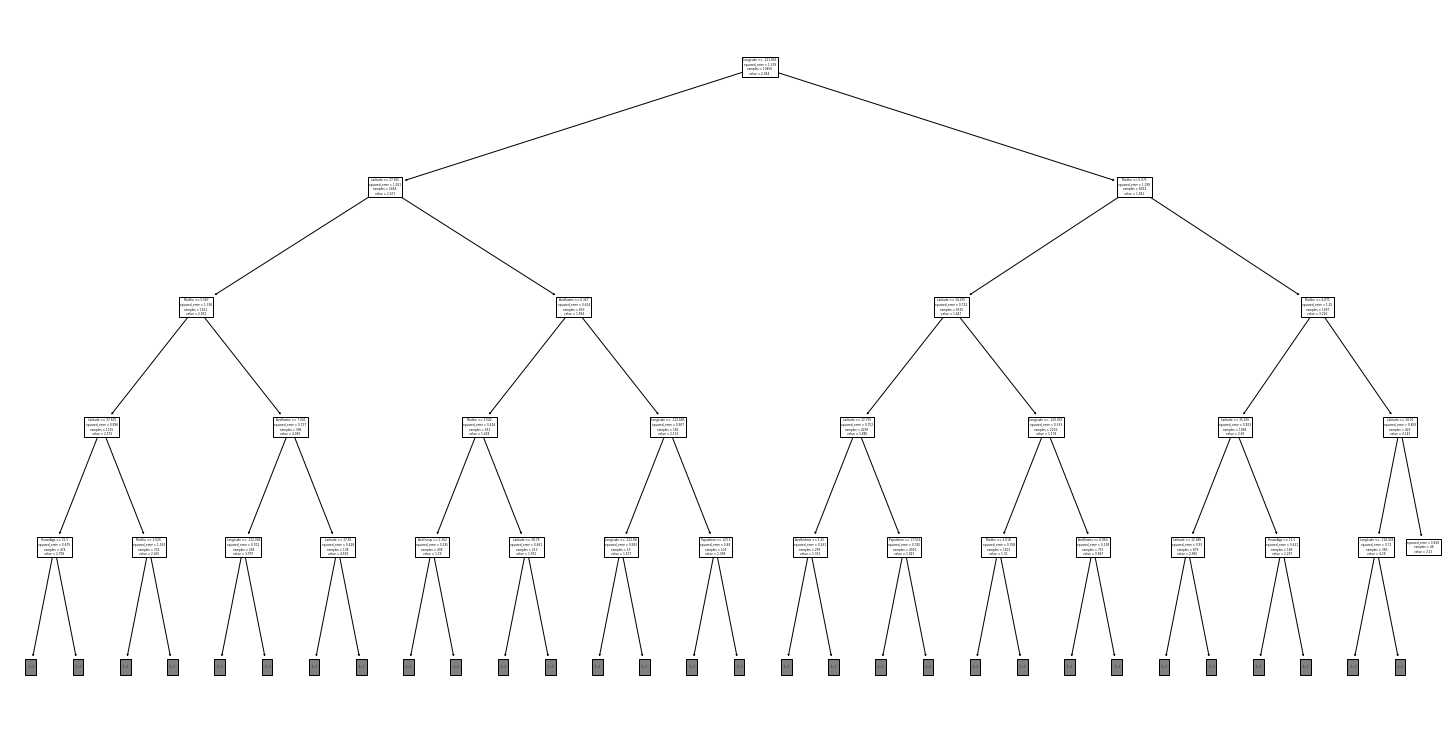

In [12]:
# Take the first decision tree
decision_tree = trf_rg.estimators_[0]

# Call the sklearn API to draw the decision tree
fig, ax = plt.subplots(figsize=(20, 10))
sklearn_tree.plot_tree(decision_tree, max_depth=4, ax=ax, feature_names=data_pp.features, class_names=True)
plt.gca().set_position([0, 0, 1, 1])
plt.savefig("rg_decision_tree_1.svg")

Draw the first Hoeffding tree in ARF.


(dot.exe:9736): Pango-WARNING **: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.

(dot.exe:1304): Pango-WARNING **: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


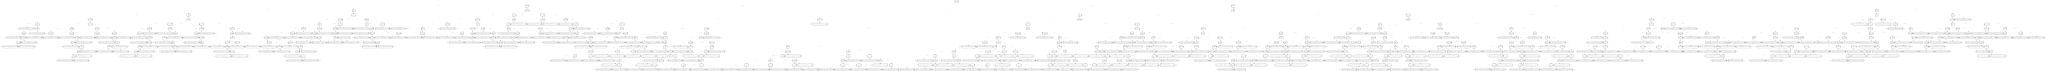

In [13]:
# Take the first hoeffding tree
tree_graph = arf_rg[0].model.draw()

# Call the graphviz API to draw the Hoeffding tree
fie_ext = 'svg'
filename = 'rg_hoeffding_tree_1'
# tree_graph = graphviz.Source(tree_graph_data)
tree_graph.render(filename, format=fie_ext, view=False)
tree_graph

**Method 2: Comparing the number of nodes in both ARF and TRF**

If the total number nodes in both ARF and TRF are the same, then the transfer learning algorithm is successful.

The number of nodes can be compared by getting the attributes for the respective base learners.

In [14]:
node_counts = {
    'TRF': [],
    'ARF': [],
    'match': []
}

for idx, (dt, ht) in enumerate(zip(trf_rg.estimators_, arf_rg)):
    dt_nc = dt.tree_.node_count
    ht_nc = ht.model.n_nodes
    node_counts['TRF'].append(dt_nc)
    node_counts['ARF'].append(ht_nc)
    node_counts['match'].append(dt_nc == ht_nc)

node_counts = pd.DataFrame(node_counts)
node_counts.index = [idx + 1 for idx in range(len(arf_rg))]
node_counts

,TRF,ARF,match
1,829,829,True
2,873,873,True
3,839,839,True
4,777,777,True
5,739,739,True
6,873,873,True
7,791,791,True
8,863,863,True
9,819,819,True
10,809,809,True


**Method 3: Comparing the tree structures**

A test is conducted to ensure that the nodes are placed at the right place in the ARF. 
The first code block outputs a log file named `arf_debug.txt`. The second code block outputs a log file named `trf_debug.txt`.  Both file contents must look the same to prove the right placements of all nodes. Each record in the file represents the location of the current internal node, and its children nodes' indexes and counts.

In [15]:
# Initialize a new ARF to prevent overwriting on existing ARF
arf_rg_tmp = AdaptiveRandomForestRegressor(**river_arf_rg_params)

# Override the max features and initialize the base learners
feature_names = data_pp.features
nominal_attrs = data_pp.nominal_attrs
arf_rg_tmp._init_ensemble(feature_names)

# Fetch the first decision tree to perform the testing
decision_tree = trf_rg.estimators_[0]

transfer_tree_weights_test(
    arf_rg_tmp[0].model,
    decision_tree,
    train_preprocessed,
    feature_names, 
    nominal_attrs, 
)


Time taken for testing the transfer learning: 12.217109441757202 seconds


In [16]:
dt = trf_rg.estimators_[0].tree_

queue = [(0, '')]

total_nodes = 0

with open(os.path.join(OUT_FOLDER_PATH, 'trf_debug.txt'), 'w') as f:
    while len(queue) > 0:
        node_idx, node_location = queue.pop(0)
        total_nodes += 1

        left_ch_idx  = dt.children_left[node_idx]
        right_ch_idx = dt.children_right[node_idx]

        if left_ch_idx != -1:
            new_node_location = node_location + '0'
            df_node_l = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_l.shape[0] != 0:
                queue.append((left_ch_idx, new_node_location))

        if right_ch_idx != -1:
            new_node_location = node_location + '1'
            df_node_r = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_r.shape[0] != 0:
                queue.append((right_ch_idx, new_node_location))

        # Write the record if and only if the current node is not the leaf node
        if left_ch_idx != -1 and right_ch_idx != -1:
            f.write(f'Node location: {node_location}\n')
            f.write(f'Left  child index: {left_ch_idx}\nCount: {df_node_l.shape[0]}\n')
            f.write(f'Right child index: {right_ch_idx}\nCount: {df_node_r.shape[0]}\n\n')

**Method 4: Training**

The transfer learning algorithm is also validated by incrementally training new samples on the ARF. The source code for training the adaptive random forest regressor can be found at **arf_training.py**. 

In [17]:
# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_rg_weight_transferred.pkl'), 'rb') as f:
    arf_rg_tmp = pickle.load(f)

X_test_pp = data_pp.preprocess(X_test)

train_arf_rg(arf_rg_tmp, X_test_pp[:1000], y_test[:1000])

Training adaptive random forest algorithm: 100%|██████████████████████| 1000/1000 [00:10<00:00, 91.28it/s]


(AdaptiveRandomForestRegressor([ForestMemberRegressor (
                                  index_original=0
                                  model=BaseTreeRegressor (
                                    max_features=3
                                    grace_period=50
                                    max_depth=inf
                                    split_confidence=0.01
                                    tie_threshold=0.05
                                    leaf_prediction="mean"
                                    leaf_model=LinearRegression (
                                      optimizer=SGD (
                                        lr=Constant (
                                          learning_rate=0.01
                                        )
                                      )
                                      loss=Squared ()
                                      l2=0.
                                      intercept_init=0.
                                     

**Method 5: Performance analysis**

The source code is in another *FYP2_ARF_RG_Performance_Analysis.ipynb*.